Name: plot_td2m.ipynb

Author: Robert M. Frost

NOAA Global Systems Laboratory

Created: 01 July 2023

Purpose: Plot dew point and wind barb comparisons of SRW output

In [13]:
from UFSutils import read_grib
import matplotlib.pyplot as plt
from matplotlib import rc
import cartopy.crs as ccrs
import cartopy.feature as cpf
import seaborn
import numpy as np
import geopandas as gpd

Important parameters

In [14]:
# hour of interest
hr = 21
# date being plot
date = "20230419"
# directory where hrrr grib data are located
dgrib_h = f"/scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/{date}00_3km_hrrrphys/{date}00/postprd/"
# directory where rap grib data are located
dgrib_r = f"/scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/{date}00_3km_rapphys/{date}00/postprd/"
# natlev or prslev
nat_prs = "natlev"
# message number for dew point
mn_td2m = 1358
# message number for u at 10m
mn_u10 = 1364
# message number for v at 10m
mn_v10 = 1365
# directory for figure to be output
figdir = f"/scratch2/BMC/fv3lam/Robby.Frost/figures/{date}/td2m/"

Plotting set up

In [15]:
rc('font',weight='normal',size=12.5)
# rc('text',usetex='True')
rc('figure',facecolor='white')

In [16]:
# NWS dew point colorbar

import matplotlib.colors as colors
a = np.array([0,10,20,30,40,45,50,55,60,65,70,75,80])
# Normalize the bin between 0 and 1 (uneven bins are important here)
norm = [(float(i)-min(a))/(max(a)-min(a)) for i in a]
# Color tuple for every bin
C = np.array([[59,34,4],
            [84,48,5],
            [140,82,10],
            [191,129,45],
            [204,168,84],
            [223,194,125],
            [230,217,181],
            [211,235,231],
            [169,219,211],
            [114,184,173],
            [49,140,133],
            [1,102,95],
            [0,60,48],
            [0,41,33]])
# Create a tuple for every color indicating the normalized position on the colormap and the assigned color.
COLORS = []
for i, n in enumerate(norm):
    COLORS.append((n, np.array(C[i])/255.))
# Create the colormap
cmap = colors.LinearSegmentedColormap.from_list("dewpoint", COLORS)

Read in dew point

In [17]:
hrrr, td2m_h, lat, lon, valid_date = read_grib(hr, dgrib_h, nat_prs, mn_td2m)
td2m_r = read_grib(hr, dgrib_r, nat_prs, mn_td2m, ret_type=1)
# convert to fahrenheit (superior unit of temperature)
td2m_h = (td2m_h.values - 273.15) * (9/5) + 32
td2m_r = (td2m_r.values - 273.15) * (9/5) + 32

Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2


Finished reading in 2 metre dewpoint temperature
Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_rapphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in 2 metre dewpoint temperature


Read in 10m wind

In [18]:
u10_h = read_grib(hr, dgrib_h, "natlev", 1364, ret_type=1).values
v10_h = read_grib(hr, dgrib_h, "natlev", 1365, ret_type=1).values
u10_r = read_grib(hr, dgrib_r, "natlev", 1364, ret_type=1).values
v10_r = read_grib(hr, dgrib_r, "natlev", 1365, ret_type=1).values

Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in 10 metre U wind component
Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_hrrrphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in 10 metre V wind component
Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_rapphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in 10 metre U wind component
Reading in /scratch2/BMC/fv3lam/Robby.Frost/expt_dirs/2023041900_3km_rapphys/2023041900/postprd/rrfs.t00z.natlev.f021.rrfs_conuscompact_3km.grib2
Finished reading in 10 metre V wind component


Plot dew point comparison

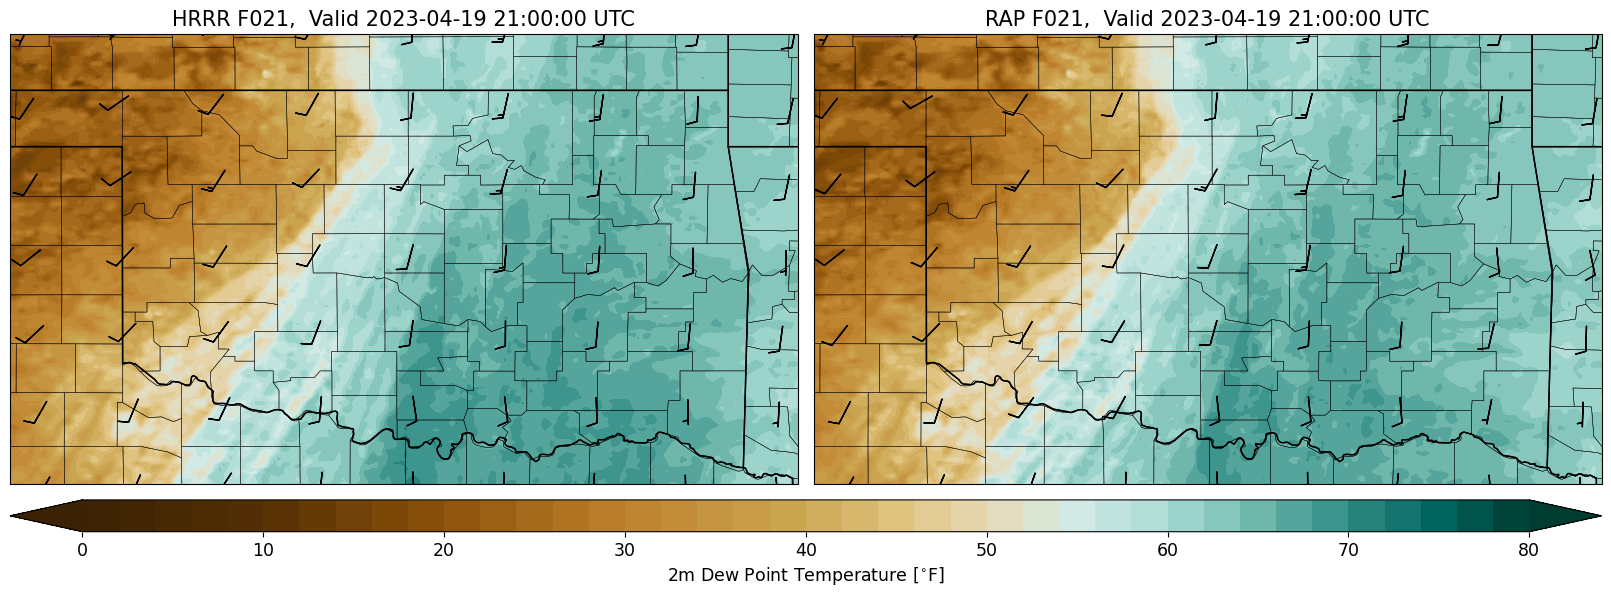

In [19]:
# Define your custom colorbar bounds
cbar_min = 0
cbar_max = 80.1
# levels for sbcape to be plot
clevs = np.arange(cbar_min, cbar_max, 2)

# create plot
fig, ax = plt.subplots(ncols=2, subplot_kw={'projection': ccrs.PlateCarree()}, 
                    figsize=(16,5.8), constrained_layout=True)

# plot HRRR
c0 = ax[0].contourf(lon, lat, td2m_h, clevs, 
                    transform=ccrs.PlateCarree(), 
                    cmap=cmap, extend="both")
# plot RAP
c1 = ax[1].contourf(lon, lat, td2m_r, clevs, 
                    transform=ccrs.PlateCarree(), 
                    cmap=cmap, extend="both")

# mapping
plt_area = [-101, -94, 33.5, 37.5] # W, E, S, N
for i, iax in enumerate(ax):
    iax.coastlines()
    iax.add_feature(cpf.BORDERS)
    iax.add_feature(cpf.STATES)
    iax.set_extent(plt_area)
    # Load the json file with county coordinates
    geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
    geoData.plot(ax=iax, color="none", lw=0.3, aspect=1)

# set title
ax[0].set_title(f"HRRR F0{hr},  Valid {valid_date} UTC")
ax[1].set_title(f"RAP F0{hr},  Valid {valid_date} UTC")

# Add colorbar
cbar = fig.colorbar(c1, ax=ax, orientation='horizontal', extend=True, pad=0.03, aspect=50)
cbar.set_label('2m Dew Point Temperature [$^{\circ}$F]')
cbar.set_ticks(np.arange(cbar_min, cbar_max, 10))

# Wind barbs
spacing=25 #barbspacing (smaller if zoomed in)
ax[0].barbs(lon[::spacing,::spacing], lat[::spacing,::spacing],
            u10_h[::spacing,::spacing], v10_h[::spacing,::spacing], 
            length=6)
ax[1].barbs(lon[::spacing,::spacing], lat[::spacing,::spacing],
            u10_r[::spacing,::spacing], v10_r[::spacing,::spacing], 
            length=6)

# save and close figure
figdir_full = f"{figdir}td2m_sidebyside_f{hr}.png"
plt.savefig(figdir_full)
plt.show()
plt.close()

td2m difference plot

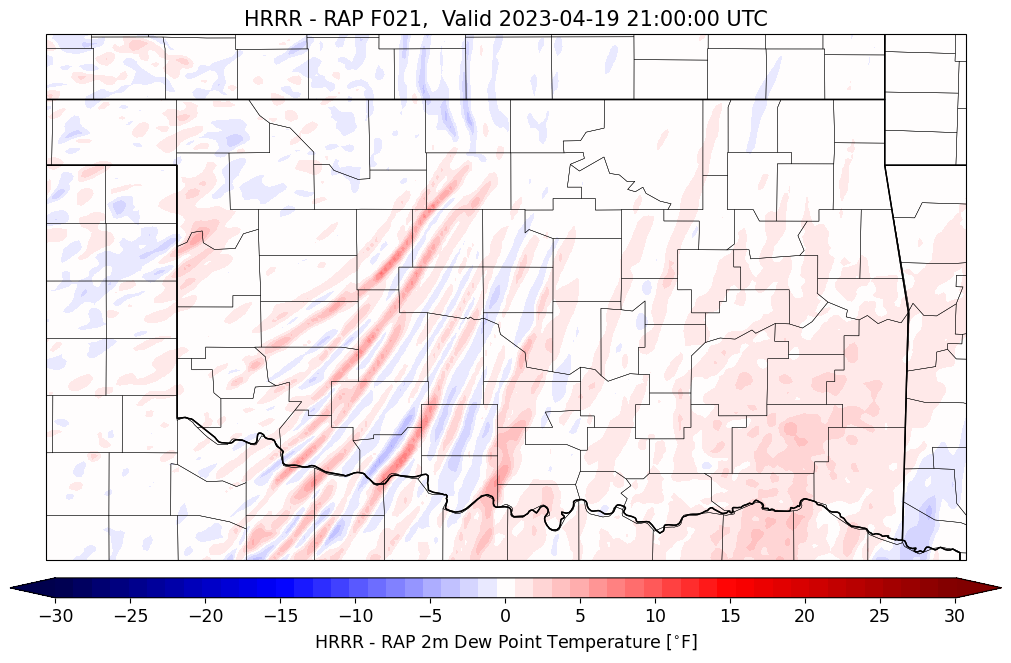

In [20]:
# Define your custom colorbar bounds
cbar_min = -30
cbar_max = 30.1
# contour levels
clevs = np.linspace(cbar_min, cbar_max, 50)
# color palette
colors = seaborn.color_palette("seismic", as_cmap=True)

# create plot
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, 
                    figsize=(10,6.5), constrained_layout=True)

# plot HRRR - RAP
c0 = ax.contourf(lon, lat, td2m_h - td2m_r,
                clevs, transform=ccrs.PlateCarree(),
                cmap=colors, extend="both")

# mapping
plt_area = [-101, -94, 33.5, 37.5] # W, E, S, N
ax.coastlines()
ax.add_feature(cpf.BORDERS)
ax.add_feature(cpf.STATES)
ax.set_extent(plt_area)
# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')
geoData.plot(ax=ax, color="none", lw=0.3, aspect=1)

# set title
ax.set_title(f"HRRR - RAP F0{hr},  Valid {valid_date} UTC")

# Add colorbar
cbar = fig.colorbar(c0, ax=ax, orientation='horizontal', extend=True, pad=0.03, aspect=50)
cbar.set_label('HRRR - RAP 2m Dew Point Temperature [$^{\circ}$F]')
cbar.set_ticks(np.arange(cbar_min, cbar_max, 5))

# save and close figure
figdir_full = f"{figdir}td2m_diff_f{hr}.png"
plt.savefig(figdir_full)
plt.show()
plt.close()